# Example showing how shapely affine transforms can be used to transform a profile (and points along it) from a local coordinates system to a cartographic coordinates system
#### O. Kaufmann, 2020.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point, LineString, Polygon
from shapely.affinity import translate, rotate, scale, skew, affine_transform
from descartes import PolygonPatch

In [3]:
def plot_shapely_obj(ax=None, obj=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    if type(obj) in (Point, LineString):
        x, y = obj.xy
        ax.plot(x, y, **kwargs)
    elif type(obj) is Polygon:
        patch = PolygonPatch(obj, **kwargs)
        ax.add_patch(patch) 
    else:
        print('Warning: Invalid object type')
    return ax

In [4]:
def plot_profile(ax=None, obj=None, name=''):
    if type(obj) is LineString:
        ax = plot_shapely_obj(ax=ax, obj=obj, color='k', linestyle='--', linewidth=0.75)
        plot_shapely_obj(ax=ax, obj=Point(obj.coords[0]), marker='o', color='g') # start
        for i in range(1, len(obj.coords)):
            plot_shapely_obj(ax=ax, obj=Point(obj.coords[i]), marker='x', color='grey')
        plot_shapely_obj(ax=ax, obj=Point(obj.coords[-1]), marker='s', color='r') # end
        theta = np.arctan2(obj.coords[-1][1]-obj.coords[0][1], obj.coords[-1][0]-obj.coords[0][0]) * 180. / np.pi
        ax.text(obj.centroid.coords[0][0], obj.centroid.coords[0][1], name, rotation=theta, 
                 horizontalalignment='center', verticalalignment='top', multialignment='center')
        ax.axis('equal')
    return ax

### The transform consist in:
- A translation to move the start point of the profile to the origin of the local system -> t1
- A rotation to align the profile on the orientation of the profile in the map (cartographic) coordinates -> r
- A scaling (should be close to 1 if units are the same) to accomodate for differences in length -> s
- A translation to bring the start of the profile at its position in the map coordinates -> t2

Left and right plots show the profile before and after each transformations

### Profile in local coordinates (extremities and eventual markers)

In [5]:
profile_start_local = Point([40., 70.])
profile_end_local = Point([90., 120.])
profile_local = LineString([profile_start_local, Point([55., 75.]), Point([60., 98.]), Point([80.,110.]), profile_end_local])

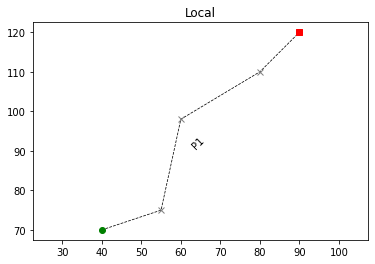

In [6]:
plot_profile(obj=profile_local, name='P1')
plt.gca().set_title('Local');

### Profile extremities in map coordinates

In [7]:
profile_start_map = Point([98227, 87122])
profile_end_map = Point([98247, 87084])
profile_map = LineString([profile_start_map, profile_end_map])

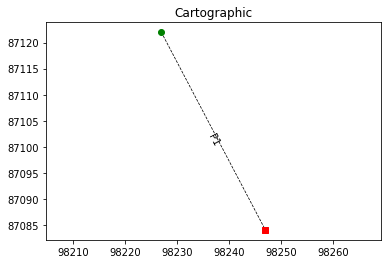

In [8]:
plot_profile(obj=profile_map, name='P1')
plt.gca().set_title('Cartographic');

### Translating

In [9]:
t1 = translate(profile_local, xoff=-profile_local.coords[0][0], yoff=-profile_local.coords[0][1])

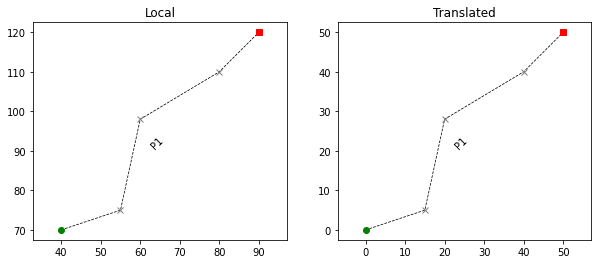

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_profile(ax=ax[0], obj=profile_local, name='P1')
plot_profile(ax=ax[1], obj=t1, name='P1')
ax[0].set_title('Local')
ax[1].set_title('Translated');

### Rotating

In [11]:
theta_local = np.arctan2(profile_local.coords[-1][1]-profile_local.coords[0][1],
                   profile_local.coords[-1][0]-profile_local.coords[0][0])
theta_map = np.arctan2(profile_map.coords[-1][1]-profile_map.coords[0][1],
                   profile_map.coords[-1][0]-profile_map.coords[0][0])
r = rotate(t1, angle=theta_map-theta_local, origin = (0.,0.), use_radians=True)

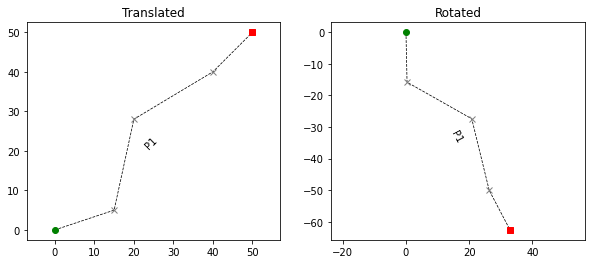

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_profile(ax=ax[0], obj=t1, name='P1')
plot_profile(ax=ax[1], obj=r, name='P1')
ax[0].set_title('Translated')
ax[1].set_title('Rotated');

### Scaling

In [13]:
scale_factor = (profile_map.length/profile_local.length)
s = scale(r, xfact=scale_factor, yfact=scale_factor,  origin=(0.,0.))

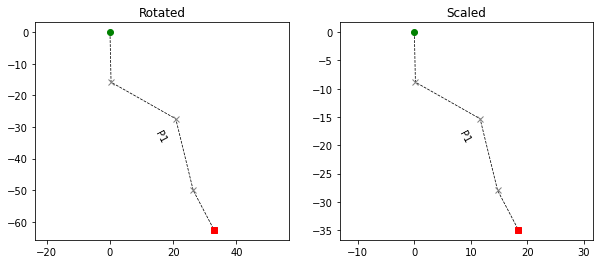

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_profile(ax=ax[0], obj=r, name='P1')
plot_profile(ax=ax[1], obj=s, name='P1')
ax[0].set_title('Rotated')
ax[1].set_title('Scaled');

### Translating

In [15]:
t2 = translate(s, xoff=profile_map.coords[0][0], yoff=profile_map.coords[0][1])

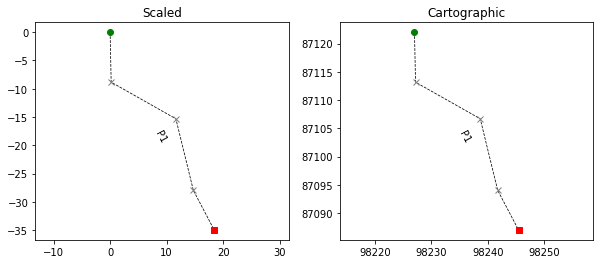

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_profile(ax=ax[0], obj=s, name='P1')
plot_profile(ax=ax[1], obj=t2, name='P1')
ax[0].set_title('Scaled')
ax[1].set_title('Cartographic');

### Transform sum up

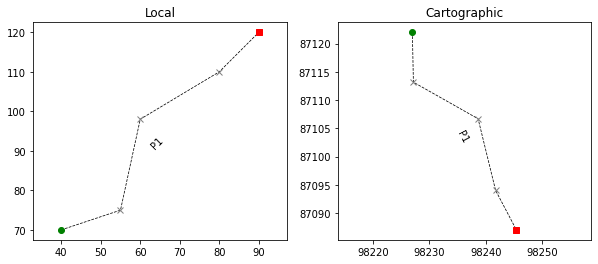

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
plot_profile(ax=ax[0], obj=profile_local, name='P1')
plot_profile(ax=ax[1], obj=t2, name='P1')
stepsize=10.
ax[0].set_title('Local')
ax[1].set_title('Cartographic');

# Alternative way using python_tools

In [19]:
from python_tools.topo.geometry import transform_matrix_2d

In [28]:
transform_matrix = transform_matrix_2d(profile_local, profile_map, shapely_format=True)

(40.0, 70.0, 90.0, 120.0) (98227.0, 87122.0, 98247.0, 87084.0)


In [29]:
new_profile_map = affine_transform(profile_local, transform_matrix)

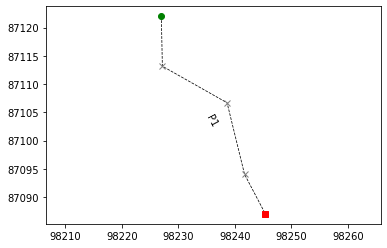

In [30]:
plot_profile(obj=new_profile_map, name='P1')